<a href="https://colab.research.google.com/github/ericdnbn/cnn-image-classifier-skin-lesions/blob/master/skin_lesion_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Skin Lesions In Dermoscopic Images Using Neural Networks

### Author: Eric Denbin


<p align="center">
  <img src=https://github.com/ericdnbn/cnn-image-classifier-skin-lesions/blob/master/images/derma.jpeg?raw=1 />
</p>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Load dependencies
import os, shutil
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.image as mpimg
import pickle


%load_ext autoreload
%autoreload 2
%matplotlib inline

## Business Understanding

Skin cancer is the most common form of cancer in the United States and worldwide. In the United States, more people are diagnosed with skin cancer each year than all other forms of cancer combined.


<p align="center">
  <img src='https://github.com/ericdnbn/cnn-image-classifier-skin-lesions/blob/master/images/skin_cancer_infographic.png?raw=1' width=500 height=200 />
</p>


Skin lesions are  first diagnosed using clinical methods, such as single image expert consensus or serial imaging of dermoscopic images. At this stage of the diagnostic process, medical professionals are visually examining the size, color, shape, uniformity, and location of skin lesions.


<p align="center">
  <img src='https://github.com/ericdnbn/cnn-image-classifier-skin-lesions/blob/master/images/single_image_consensus_example.png?raw=1' width=550 height=250 />
</p>


If a diagnosis is uncertain, more clinical tests may be performed. These include blood tests, allergy tests, and skin swabs, among others. At this point, if a lesion is suspicious for malignancy, or the diagnosis is still uncertain, the specific type of lesion is determined by analyzing a biopsy under a microscope.


<p align="center">
  <img src='https://github.com/ericdnbn/cnn-image-classifier-skin-lesions/blob/master/images/biopsy.jpeg?raw=1' width=400 height=200 />
</p>


When it comes to clinically diagnosing skin lesions, medical professionals often misdiagnose benign lesions as being suspicious for malignancy. According to a study published in April of 2021 in the Dermatology Research And Practice Journal, while 99.06% of the lesions clinically diagnosed as benign were actually benign, just 82.85% of all benign lesions were identified (https://www.hindawi.com/journals/drp/2021/6618990). This results in an inefficient use of resources. A study published in the Journal Of Clinical Oncology in June of 2018, estimated that biopsies of benign lesions cost between \\$624 million and $1.7 billion over the course of a year (https://ascopubs.org/doi/abs/10.1200/JCO.2018.36.15_suppl.e18903).

Given those facts, a model could be used to identify misdiagnosed benign lesions, and therefore reduce the number of biopsies taken of benign lesions.


## Data Understanding


My dataset consists of 7,179 dermoscopic images from the International Skin Imaging Collaboration(ISIC) archive (https://www.isic-archive.com/). All patients were 10-90 years old and the images were taken in the course of clinical care.

The ISIC archive contains over 150,000 images, 70,000 of which have been made public. I downloaded only dermoscopic images to ensure a certain standard of quality across the dataset. The archive contains 23,704 dermoscopic images of benign lesions, 2,240 dermoscopic images of malignant lesions, and 2,212 dermoscopic images of unknown lesions. I downloaded 2,401 images of benign lesions for training and validation, and 980 images of benign lesions for testing. I downloaded 1500 dermoscopic images of malignant lesions for training and validation, and 600 for testing. I downloaded 1500 dermoscopic images of unknown lesions for training and validation, and 600 for testing. The class balance in my training set is 44.44% images of benign lesions, 27.78% images of malignant lesions, and 27.78% images of unknown lesions.

The following file structure provides the ground truth labeling needed to train the models. If you wish to run my code, you will need to download images from the ISIC archive into the same directory format:
```
└── dermoscopic_images
    ├── train
    │    ├──benign
    |    ├──malignant
    │    └──unknown
    └── test
         ├──benign
         ├──malignant
         └──unknown
```


## Exploratory Data Analysis

To load the dataset using Keras's ImageDataGenerator class with the flow_from_directory method, we first need to specify the filepaths used to access the image folders.

In [4]:
functions_path = '/content/drive/MyDrive/Colab Notebooks/' 
sys.path.append(os.path.abspath(functions_path))
from functions import visualize_images, preprocessing_dense_data, visualize_nn, visualize_nn_test, nn_model, cnn_preprocessing, visualize_cnn, visualize_cnn_test, cnn_model

In [5]:
# Filepaths
train_dir = '/content/drive/MyDrive/Colab Notebooks/dermoscopic_images/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/dermoscopic_images/test/' 

# Check functionality and num images
train_benign_dir = os.path.join(train_dir, 'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')
train_unknown_dir = os.path.join(train_dir, 'unknown')
train_benign_dir

test_benign_dir = os.path.join(test_dir, 'benign')
test_malignant_dir = os.path.join(test_dir, 'malignant')
test_unknown_dir = os.path.join(test_dir, 'unknown')

In [6]:
# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [ ]:
# Check number of files
print('There are', len(os.listdir(train_benign_dir)), 'benign images in the training set')
print('There are', len(os.listdir(train_malignant_dir)), 'malignant images in the training set')
print('There are', len(os.listdir(train_unknown_dir)), 'unknown images in the training set')
print('')
print('There are', len(os.listdir(test_benign_dir)), 'benign images in the testing set')
print('There are', len(os.listdir(test_malignant_dir)), 'malignant images in the testing set')
print('There are', len(os.listdir(test_unknown_dir)), 'unknown images in the testing set')

There are 2401 benign images in the training set
There are 1500 malignant images in the training set
There are 1500 unknown images in the training set

There are 980 benign images in the testing set
There are 600 malignant images in the testing set
There are 579 unknown images in the testing set


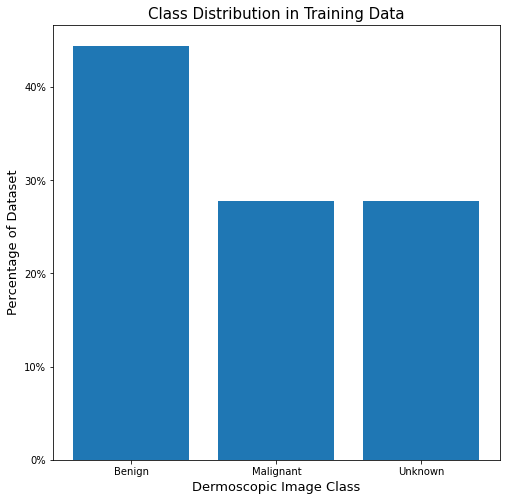

In [ ]:
# Visualize class distribution in training data
total_images = len(os.listdir(train_benign_dir)) + len(os.listdir(train_malignant_dir)) + len(os.listdir(train_unknown_dir))
fig, ax = plt.subplots(figsize=(8, 8))

ax.bar(x=['Benign', 'Malignant', 'Unknown'], height=[len(os.listdir(train_benign_dir))/total_images, 
                                          len(os.listdir(train_malignant_dir))/total_images,
                                          len(os.listdir(train_unknown_dir))/total_images])
ax.set_title('Class Distribution in Training Data', size=15)
ax.set_ylabel('Percentage of Dataset', size=13)
ax.set_xlabel('Dermoscopic Image Class', size=13)
ax.set_yticklabels([str(int(p*100))+'%' for p in ax.get_yticks()])
plt.show()

There is a slight imbalance in the dataset with 44.44% of the images being in the benign class, 27.78% in the malignant class, and 27.78% in the unknown class. This imbalance is representative of the class balance in the archive.

In [ ]:
# Create a list containing the path to each image in the subsets of the training data
train_benign_filepaths = [os.path.join(train_benign_dir, name) for name in os.listdir(train_benign_dir)]
train_malignant_filepaths = [os.path.join(train_malignant_dir, name) for name in os.listdir(train_malignant_dir)]
train_unknown_filepaths = [os.path.join(train_unknown_dir, name) for name in os.listdir(train_unknown_dir)]

In [ ]:
# Load in five images from each subset of the training data
tr_benign_images = [mpimg.imread(img) for img in train_benign_filepaths[:5]]
tr_malignant_images = [mpimg.imread(img) for img in train_malignant_filepaths[:5]]
tr_unknown_images = [mpimg.imread(img) for img in train_unknown_filepaths[:5]]

In [ ]:
# Create a list of tuples of the images I pulled in from each class and a string representing each class
images = [(tr_benign_images, 'Benign'), (tr_malignant_images, 'Malignant'), (tr_unknown_images, 'Unknown')]

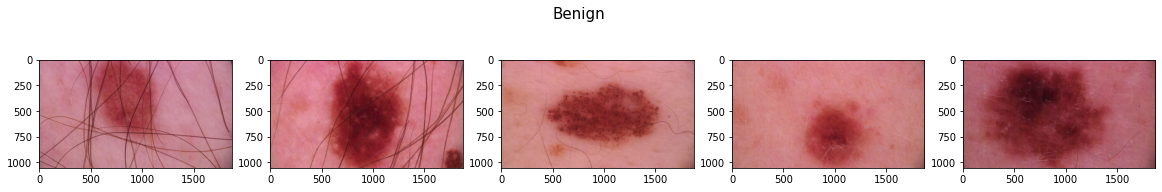

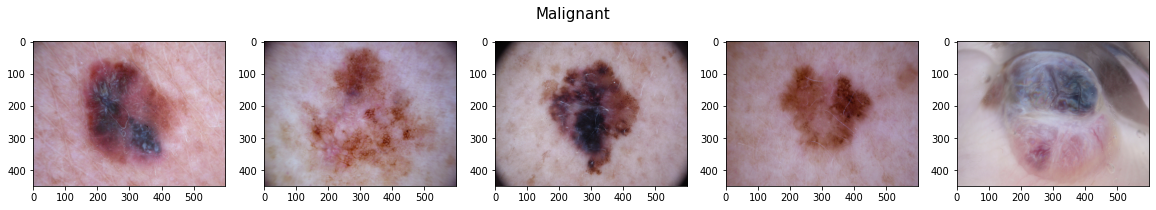

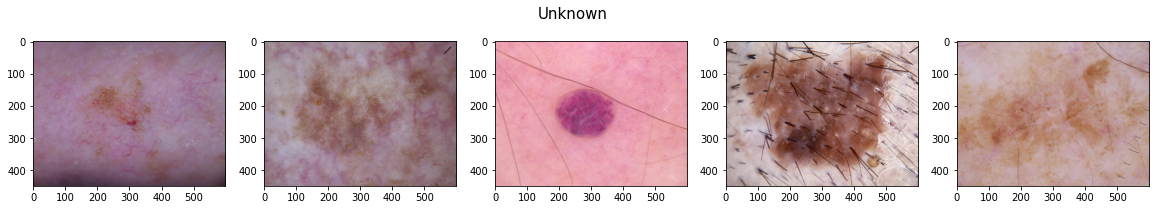

In [ ]:
# Visualize the images in each class using a custom function – to see the code for the function, reference the functions.py file in the code folder
for im, name in images:
    visualize_images(im, name)

## Modeling With Neural Networks

To load the data for each model, I call a custom preprocessing function that uses the ImageDataGenerator object from Keras with the .flowfromdirectory() method called off of it to return a data generator for the training set, the validation set, and optionally, the testing set – to see the code for this function, reference the functions.py file in the code folder.

### First Simple Model

The first simple model I trained consists of a fully connected dense neural network with two hidden layers, plus an output layer. This model serves as a proof of concept and provides baseline metrics.

In [ ]:
# Load the data with custom function
train_gen, val_gen = preprocessing_dense_data(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [ ]:
# Create the architecture of the model
model = models.Sequential()
model.add(Flatten(input_shape=(128,128,3)))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Recall'])

# Fit the model
history=model.fit(train_gen,
                  steps_per_epoch=33,
                  epochs=5,
                  validation_data=val_gen,
                  validation_steps=8)

Epoch 1/5
33/33 [==============================] - 279s 9s/step - loss: 3.4759 - accuracy: 0.4143 - recall: 0.0625 - val_loss: 1.0953 - val_accuracy: 0.4688 - val_recall: 0.0000e+00
Epoch 2/5
33/33 [==============================] - 271s 8s/step - loss: 1.0944 - accuracy: 0.4455 - recall: 0.0000e+00 - val_loss: 1.0913 - val_accuracy: 0.4688 - val_recall: 0.0000e+00
Epoch 3/5
33/33 [==============================] - 271s 8s/step - loss: 1.0910 - accuracy: 0.4453 - recall: 0.0000e+00 - val_loss: 1.0871 - val_accuracy: 0.4688 - val_recall: 0.0000e+00
Epoch 4/5
33/33 [==============================] - 270s 8s/step - loss: 1.0880 - accuracy: 0.4429 - recall: 0.0000e+00 - val_loss: 1.0835 - val_accuracy: 0.4688 - val_recall: 0.0000e+00
Epoch 5/5
33/33 [==============================] - 269s 8s/step - loss: 1.0854 - accuracy: 0.4422 - recall: 0.0000e+00 - val_loss: 1.0799 - val_accuracy: 0.4688 - val_recall: 0.0000e+00


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1572896   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 1,573,187
Trainable params: 1,573,187
Non-trainable params: 0
_________________________________________________________________


To visualize the results of each model, I used a custom function that graphed the metrics across each epoch, evaluated the model using the train and validation sets, and plotted a confusion matrix of the results of the evaluation of the validation set – to see the code for this function, reference the functions.py file in the code folder. 

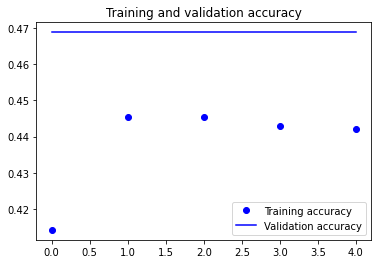

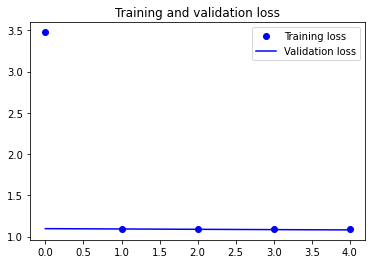

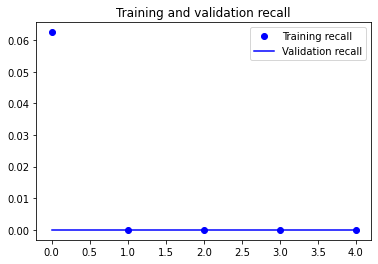


Training Evaluation:
34/34 [==============================] - 159s 5s/step - loss: 1.0837 - accuracy: 0.4446 - recall: 0.0000e+00

Validation Evaluation:
9/9 [==============================] - 117s 14s/step - loss: 1.0837 - accuracy: 0.4444 - recall: 0.0000e+00

Validation Confusion Matrix



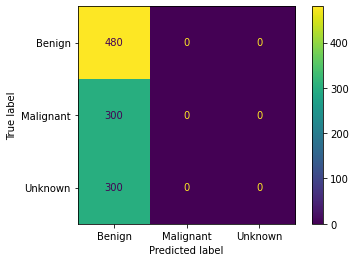

In [ ]:
# Visualize the results with custom function
visualize_nn(history, model, train_gen, val_gen, multi=True, labels=['Benign', 'Malignant', 'Unknown'])

**Analysis:** The first simple model returned a validation accuracy of 44.44%, as it predicted every image to be a part of the benign class. Given that I trained it for just five epochs to get a proof of concept, these results were as much as I expected.

### Iterating On Convolutional Neural Networks

To improve on the first simple model, I began iterating on convolutional neural networks. The following are various adjustments made over these iterations to improve model performance:
 - Adding more dense layers
 - Adding convolutional layers
 - Adding dropout layers
 - Adding batch normalization layers
 - Using L2 regularization
 - Trying different kernel sizes

In [ ]:
# Load the data with custom function
train_gen_c, val_gen_c = cnn_preprocessing(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [ ]:
# Create a callback function that saves the model after an epoch where it achieves its highest validation accuracy 
checkpoint_filepath_c='/content/drive/MyDrive/Colab Notebooks/checkpoint_models/checkpoint_model_c.h5'
my_callback_c=ModelCheckpoint(filepath=checkpoint_filepath_c, monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
# Create the architecture of the model
c_model = models.Sequential()

c_model.add(Conv2D(256, kernel_size=(3,3), activation='relu',input_shape=(128,128,3)))
c_model.add(MaxPooling2D(2,2))
c_model.add(Conv2D(64, kernel_size=(5,5), activation='relu', kernel_regularizer=l2(l2=0.001)))
c_model.add(MaxPooling2D(2,2))
c_model.add(Conv2D(16, kernel_size=(3,3), kernel_regularizer=l2(l2=0.001)))
c_model.add(BatchNormalization())
c_model.add(Activation('relu'))
c_model.add(MaxPooling2D(2,2))

c_model.add(Flatten())

c_model.add(Dense(8, activation='relu', kernel_regularizer=l2(l2=0.001)))
c_model.add(Dense(4, kernel_regularizer=l2(l2=0.001)))
c_model.add(BatchNormalization())
c_model.add(Activation('relu'))
c_model.add(Dense(3, activation='softmax'))
            
            
c_model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy', 'Recall'])
            
# Fit the model
c_history = c_model.fit(train_gen_c,
                      steps_per_epoch=33,
                      epochs=25,
                      validation_data=(val_gen_c),
                      validation_steps=8,
                      callbacks=my_callback_c)

Epoch 1/25
33/33 [==============================] - 335s 10s/step - loss: 1.0413 - accuracy: 0.6155 - recall: 0.2912 - val_loss: 1.2354 - val_accuracy: 0.2500 - val_recall: 0.0127
Epoch 2/25
33/33 [==============================] - 326s 10s/step - loss: 0.9084 - accuracy: 0.6804 - recall: 0.4748 - val_loss: 1.0741 - val_accuracy: 0.4932 - val_recall: 0.4678
Epoch 3/25
33/33 [==============================] - 327s 10s/step - loss: 0.8262 - accuracy: 0.7892 - recall: 0.5485 - val_loss: 0.9771 - val_accuracy: 0.5342 - val_recall: 0.4600
Epoch 4/25
33/33 [==============================] - 326s 10s/step - loss: 0.7655 - accuracy: 0.8001 - recall: 0.5769 - val_loss: 1.1403 - val_accuracy: 0.4688 - val_recall: 0.4688
Epoch 5/25
33/33 [==============================] - 327s 10s/step - loss: 0.7149 - accuracy: 0.8037 - recall: 0.5912 - val_loss: 0.9801 - val_accuracy: 0.6729 - val_recall: 0.1475
Epoch 6/25
33/33 [==============================] - 326s 10s/step - loss: 0.6576 - accuracy: 0.8221 

In [ ]:
# Save the model 
c_model.save('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/c_model.h5')

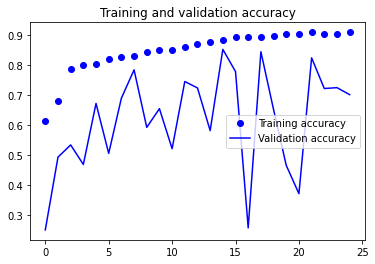

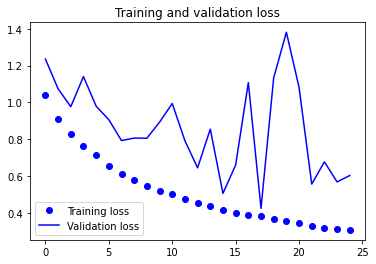

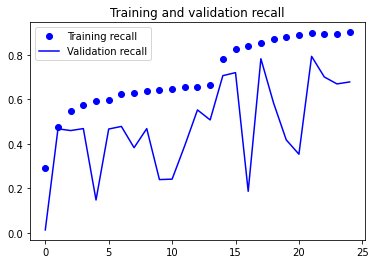


Training Evaluation:
34/34 [==============================] - 182s 5s/step - loss: 0.5577 - accuracy: 0.6980 - recall: 0.6785

Validation Evaluation:
9/9 [==============================] - 137s 16s/step - loss: 0.6312 - accuracy: 0.6676 - recall: 0.6454

Validation Confusion Matrix



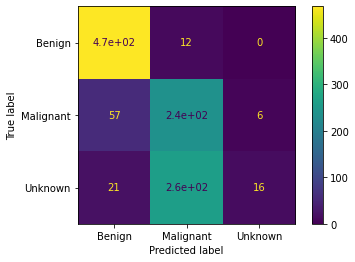

In [ ]:
# Visualize the results with custom function
visualize_cnn(c_history, c_model, train_gen_c, val_gen_c, multi=True, labels=['Benign', 'Malignant', 'Unknown'])

**Analysis:** The first convolutional neural network I trained returned a validation accuracy of 66.76%. As the confusion matrix demonstrates, this model began to distinguish the difference between the benign and malignant classes. However, it still had trouble correctly classifying images of unknown lesions. 

In [ ]:
# Load the data with custom function
train_gen_cnn, val_gen_cnn = cnn_preprocessing(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [ ]:
# Create a callback function that saves the model after an epoch where it achieves its highest validation accuracy 
checkpoint_filepath_cnn='/content/drive/MyDrive/Colab Notebooks/checkpoint_models/cnn_checkpoint_model.h5'
my_callback_cnn=ModelCheckpoint(filepath=checkpoint_filepath_cnn, monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
# Create the architecture of the model
cnn_model = models.Sequential()

cnn_model.add(Conv2D(256, kernel_size=(5,5), activation='relu',input_shape=(128,128,3)))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(64, kernel_size=(3,3), kernel_regularizer=l2(l2=0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(16, kernel_size=(5,5), kernel_regularizer=l2(l2=0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(l2=0.001)))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Flatten())

cnn_model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2=0.001)))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(16, kernel_regularizer=l2(l2=0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(4, kernel_regularizer=l2(l2=0.001)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(3, activation='softmax'))
            
            
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'Recall'])
            
# Fit the model
cnn_history = cnn_model.fit(train_gen_cnn,
                            steps_per_epoch=33,
                            epochs=25,
                            validation_data=(val_gen_cnn),
                            validation_steps=8,
                            callbacks=my_callback_cnn)

Epoch 1/25
33/33 [==============================] - 280s 8s/step - loss: 1.3938 - accuracy: 0.6010 - recall: 0.2213 - val_loss: 1.4594 - val_accuracy: 0.4717 - val_recall: 9.7656e-04
Epoch 2/25
33/33 [==============================] - 273s 8s/step - loss: 1.1901 - accuracy: 0.7262 - recall: 0.3694 - val_loss: 1.3295 - val_accuracy: 0.4727 - val_recall: 0.4668
Epoch 3/25
33/33 [==============================] - 272s 8s/step - loss: 1.0671 - accuracy: 0.7613 - recall: 0.4310 - val_loss: 1.2192 - val_accuracy: 0.4932 - val_recall: 0.4648
Epoch 4/25
33/33 [==============================] - 273s 8s/step - loss: 0.9616 - accuracy: 0.7901 - recall: 0.4891 - val_loss: 1.2925 - val_accuracy: 0.3857 - val_recall: 0.0498
Epoch 5/25
33/33 [==============================] - 273s 8s/step - loss: 0.8735 - accuracy: 0.8111 - recall: 0.5402 - val_loss: 1.3340 - val_accuracy: 0.2734 - val_recall: 0.1113
Epoch 6/25
33/33 [==============================] - 273s 8s/step - loss: 0.7963 - accuracy: 0.8137 - 

In [ ]:
# Save the model
cnn_model.save('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/cnn_model.h5')

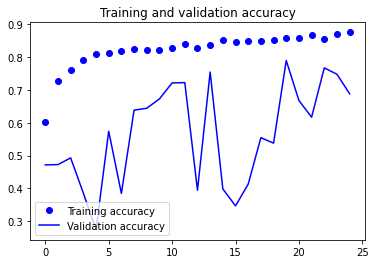

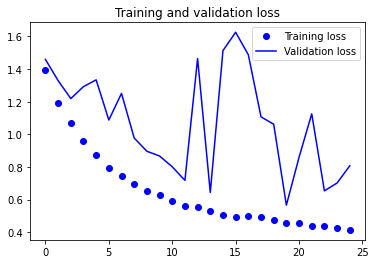

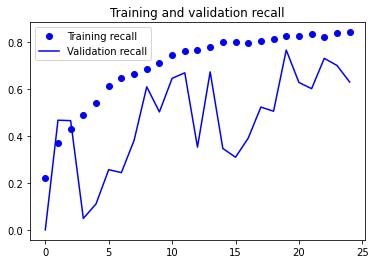


Training Evaluation:
34/34 [==============================] - 161s 5s/step - loss: 0.7584 - accuracy: 0.7278 - recall: 0.6765

Validation Evaluation:
9/9 [==============================] - 118s 14s/step - loss: 0.8021 - accuracy: 0.6843 - recall: 0.6269

Validation Confusion Matrix



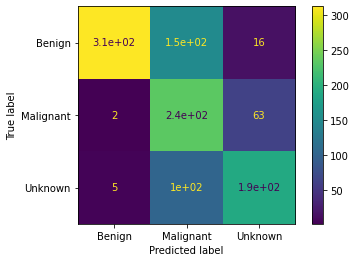

In [ ]:
# Visualize the results with custom function
visualize_cnn(cnn_history, cnn_model, train_gen_cnn, val_gen_cnn, multi=True, labels=['Benign', 'Malignant', 'Unknown'])

**Analysis:** The second convolutional neural network returned a validation accuracy of 68.43%. Although this model performed worse in regard to predicting the benign class, this iteration was able to distinguish between all three classes.  


### Iterating On Pre-Trained Convolutional Neural Networks

Once the performance of the convolutional neural networks I trained using custom architecture plateaued, I began exploring transfer learning. I used the pre-trained VGG16 model with the 'imagenet' weights as a base, and the same architecture from my best convolutional neural network to construct the fully connected dense layers. The following are other adjustments I made as I continued iterating:
 - Increasing the number of dense layers 
 - Increasing the number of nodes in the first hidden layer with each additional layer

In [ ]:
# Load the data with custom function
train_gen_transfer, val_gen_transfer = preprocessing_dense_data(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [ ]:
# Create a callback function that saves the model after an epoch where it achieves its highest validation accuracy 
checkpoint_filepath='/content/drive/MyDrive/Colab Notebooks/checkpoint_models/checkpoint_model1.h5'
my_callback=ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_recall', save_best_only=True, mode='max')

In [ ]:
# Create the architecture of the model
base_model = VGG16(weights='imagenet', input_shape=(128,128,3), include_top=False)
for layers in base_model.layers:
  layers.trainable=False

transfer_model = models.Sequential()

transfer_model.add(base_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2=0.001)))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(16, kernel_regularizer=l2(l2=0.001)))
transfer_model.add(BatchNormalization())
transfer_model.add(Activation('relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(4, kernel_regularizer=l2(l2=0.001)))
transfer_model.add(BatchNormalization())
transfer_model.add(Activation('relu'))
transfer_model.add(Dense(3, activation='softmax'))
            
            
transfer_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy', 'Recall'])
            
# Fit the model
transfer_history = transfer_model.fit(train_gen_transfer,
                                      steps_per_epoch=33,
                                      epochs=25,
                                      validation_data=(val_gen_transfer),
                                      validation_steps=8,
                                      callbacks=my_callback)

Epoch 1/25
33/33 [==============================] - 340s 10s/step - loss: 1.3979 - accuracy: 0.3713 - recall: 0.1026 - val_loss: 1.1821 - val_accuracy: 0.4805 - val_recall: 0.2090
Epoch 2/25
33/33 [==============================] - 319s 10s/step - loss: 1.1590 - accuracy: 0.5230 - recall: 0.1073 - val_loss: 1.1137 - val_accuracy: 0.7051 - val_recall: 0.0518
Epoch 3/25
33/33 [==============================] - 316s 10s/step - loss: 1.0616 - accuracy: 0.6492 - recall: 0.1297 - val_loss: 1.0683 - val_accuracy: 0.7324 - val_recall: 0.0166
Epoch 4/25
33/33 [==============================] - 319s 10s/step - loss: 1.0081 - accuracy: 0.6897 - recall: 0.1462 - val_loss: 1.0189 - val_accuracy: 0.7305 - val_recall: 0.0498
Epoch 5/25
33/33 [==============================] - 315s 10s/step - loss: 0.9681 - accuracy: 0.7098 - recall: 0.1655 - val_loss: 1.0361 - val_accuracy: 0.6104 - val_recall: 0.0420
Epoch 6/25
33/33 [==============================] - 316s 10s/step - loss: 0.9258 - accuracy: 0.7379 

In [ ]:
# Save the model
transfer_model.save('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/transfer_model.h5')

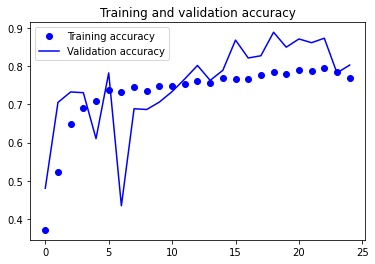

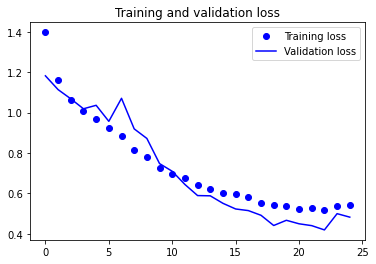

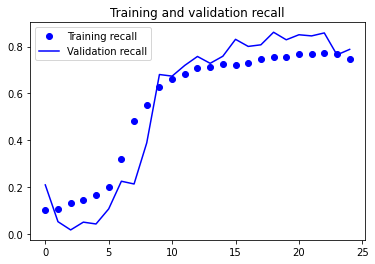


Training Evaluation:
34/34 [==============================] - 183s 5s/step - loss: 0.4656 - accuracy: 0.8336 - recall: 0.8243

Validation Evaluation:
9/9 [==============================] - 137s 16s/step - loss: 0.4836 - accuracy: 0.8120 - recall: 0.7981

Validation Confusion Matrix



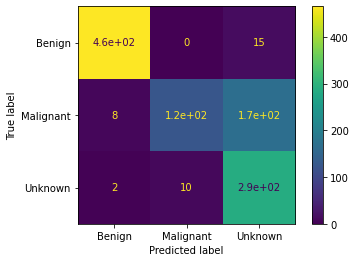

In [ ]:
# Visualize the results of the model
visualize_cnn(transfer_history, transfer_model, train_gen_transfer, val_gen_transfer, multi=True, labels=['Benign', 'Malignant', 'Unknown'])


**Analysis:** The first model I trained using the pre-trained VGG16 model as a base returned a validation accuracy of 81.20%. Crucially, as the metric graphs show, this model's learning process was quite smooth with low volatility from one epoch to next. Of even more importance is that this model performed the best as it relates to the business problem, predicting the benign class with a precision of 97.87% and a recall of 96.84%. Using these values, the F1 score comes out to 97.35.

In [ ]:
# Load the data with custom function
train_gen_transfer2, val_gen_transfer2 = preprocessing_dense_data(train_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical')

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.


In [ ]:
# Create a callback function that saves the model after an epoch where it achieves its highest validation accuracy 
checkpoint_filepath2='/content/drive/MyDrive/Colab Notebooks/checkpoint_models/checkpoint_model2.h5'
my_callback2=ModelCheckpoint(filepath=checkpoint_filepath2, monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
# Create the architecture of the model
base_model2 = VGG16(weights='imagenet', input_shape=(128,128,3), include_top=False)
for layers in base_model2.layers:
  layers.trainable=False

transfer_model2 = models.Sequential()

transfer_model2.add(base_model2)
transfer_model2.add(Flatten())
transfer_model2.add(Dense(512, activation='relu', kernel_regularizer=l2(l2=0.001)))
transfer_model2.add(Dropout(0.5))
transfer_model2.add(Dense(256, kernel_regularizer=l2(l2=0.001)))
transfer_model2.add(BatchNormalization())
transfer_model2.add(Activation('relu'))
transfer_model2.add(Dropout(0.5))
transfer_model2.add(Dense(16, kernel_regularizer=l2(l2=0.001)))
transfer_model2.add(BatchNormalization())
transfer_model2.add(Activation('relu'))
transfer_model2.add(Dropout(0.5))
transfer_model2.add(Dense(4, kernel_regularizer=l2(l2=0.001)))
transfer_model2.add(BatchNormalization())
transfer_model2.add(Activation('relu'))
transfer_model2.add(Dense(3, activation='softmax'))
            
            
transfer_model2.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy', 'Recall'])
            
# Fit the model
transfer_history2 = transfer_model2.fit(train_gen_transfer2,
                                        steps_per_epoch=33,
                                        epochs=35,
                                        validation_data=(val_gen_transfer2),
                                        validation_steps=8,
                                        callbacks=my_callback2)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/35
33/33 [==============================] - 3060s 93s/step - loss: 1.8580 - accuracy: 0.3876 - recall: 0.1271 - val_loss: 1.4770 - val_accuracy: 0.5518 - val_recall: 0.3066
Epoch 2/35
33/33 [==============================] - 304s 9s/step - loss: 1.3561 - accuracy: 0.5707 - recall: 0.1987 - val_loss: 1.1656 - val_accuracy: 0.6924 - val_recall: 0.5322
Epoch 3/35
33/33 [==============================] - 275s 8s/step - loss: 1.1680 - accuracy: 0.6537 - recall: 0.2764 - val_loss: 1.0162 - val_accuracy: 0.7002 - val_recall: 0.5166
Epoch 4/35
33/33 [==============================] - 273s 8s/step - loss: 1.0501 - accuracy: 0.6823 - recall: 0.3732 - val_loss: 1.0202 - val_accuracy: 0.7520 - val_recall: 0.4326
Epoch 5/35
33/33 [==============================] - 272s 8s/step - loss: 0.9625 - accuracy: 0.7167 - recall: 0.4448 - val_loss: 0.9903 - val_accuracy: 0.7266 - val_recall: 0.4678
Epoch 6/35
33/33 [====================

In [ ]:
# Save the model
transfer_model2.save('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/transfer_model2.h5')

In [ ]:
# Load the model to see the summary
transfer_model2 = models.load_model('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/transfer_model2.h5')

transfer_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0

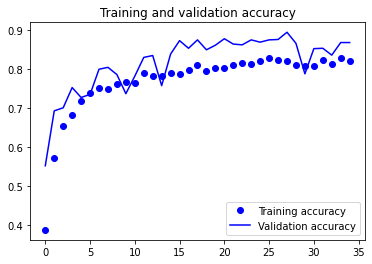

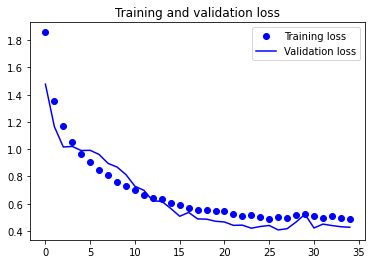

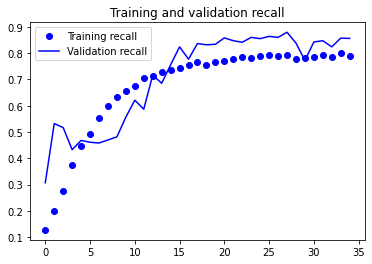


Training Evaluation:
34/34 [==============================] - 163s 5s/step - loss: 0.4164 - accuracy: 0.8729 - recall: 0.8637

Validation Evaluation:
9/9 [==============================] - 120s 14s/step - loss: 0.4378 - accuracy: 0.8630 - recall: 0.8528

Validation Confusion Matrix



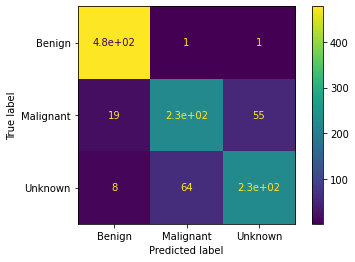

In [ ]:
# Visualize the results with custom function
visualize_cnn(transfer_history2, transfer_model2, train_gen_transfer2, val_gen_transfer2, multi=True, labels=['Benign', 'Malignant', 'Unknown'])


**Analysis:** The second model I trained using the pre-trained VGG16 as a base returned the best validation accuracy at 86.30%, and predicted the benign class with a precision of 94.67% and a recall of 99.59%. Using these values, the F1 score as it relates to predicting the benign class comes out to 97.07.

## **Best Model**

After iterating through many models, I chose the first model I trained using the pre-trained VGG16 as the best model based on its F1 score as it relates to predicting the benign class.

In [7]:
# Load best model
best_model = models.load_model('/content/drive/MyDrive/Colab Notebooks/saved_finished_models/transfer_model.h5')

In [8]:
train_gen_eval, val_gen_eval, test_gen_eval = cnn_preprocessing(train_dir, test_dir, ts_tuple=(128,128), color='rgb', batch_size=128, class_mode='categorical', process_test=True)

Found 4321 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.
Found 2159 images belonging to 3 classes.


In [9]:
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                4112      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
activation_2 (Activation)    (None, 16)               

## Final Evaluation

Best Model Evaluation On Test Set:
17/17 [==============================] - 1813s 112s/step - loss: 0.5308 - accuracy: 0.7531 - recall: 0.7406

Confusion Matrix Test Set:



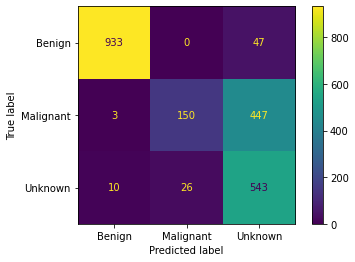

In [10]:
# Evaluate the best model on the test set
print('Best Model Evaluation On Test Set:')
best_model.evaluate(test_gen_eval)

# Get array of predictions for confusion matrix
preds = np.argmax(best_model.predict(test_gen_eval), -1)

# Create confusion matrix
cm = confusion_matrix(test_gen_eval.classes, preds)

# Visualize confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant', 'Unknown'])

print('')
print('Confusion Matrix Test Set:')
print('')
cmd.plot(values_format='d');

**Analysis:**  The accuracy of the best model on the test set was just 75.31%, but in terms of my key metric, F1 score as it relates to predicting the benign class, it performed quite well.

Out of 946 lesions the model predicted to be benign, 933 are benign, 3 are malignant, and 10 are unknown. This means that its precision when predicting lesions to be benign is 98.63%, which is less than a half of a percent lower than the precision of medical professionals clinically diagnosing lesions as being benign. 

Out of 980 total benign lesions, the model was able to identify 933. This means that its recall when predicting lesions to be benign is 95.20%, which is about 13% better than the recall of medical professionals clinically diagnosing lesions as being benign. 

Using these values for precision and recall, the F1 score as it relates to predicting the benign class comes out to 96.88. 

It is important to note that the model does have trouble distinguishing between malignant and unknown lesions, as demonstrated by the 447 malignant lesions the model predicted to be unknown. However, as it relates to the business problem, this is irrelevant, because a biopsy would be taken regardless of whether a lesion is predicted to be malignant or unknown. What is important is that there are no benign lesions predicted to be malignant, and only 4.80% of all benign lesions are predicted to be unknown.

Given the model’s precision and recall as it relates to predicting the benign class, it could successfully be used to identify misdiagnosed benign lesions, and therefore reduce the number of biopsies taken of benign lesions.

## Visualizing The Blackbox with Lime
*https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb*

In [11]:
# Load the dependenices necessary to use the lime package
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from keras.applications import inception_v3 as inc_net

%load_ext autoreload
%autoreload 2
!pip install lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
     |████████████████████████████████| 275 kB 4.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=09223717ab4559b96e0e61f9d11de77479452eb4b4b73402942fa766f6958591
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


First, I am going to retrieve three correctly classified images and three misclassified images.

In [12]:
# From https://stackoverflow.com/questions/39300880/how-to-find-wrong-prediction-cases-in-test-set-cnns-using-keras
# Get indices of correctly classified images
corrects = np.nonzero(preds == test_gen_eval.labels)[0]

# Get indices of misclassfied images
incorrects = np.nonzero(preds != test_gen_eval.labels)[0]

In [13]:
len(incorrects)

533

In [14]:
len(corrects)

1626

In [15]:
filenames = test_gen_eval.filenames

In [16]:
# Creating empty lists to store the filenames of misclassified images in each class
benign_incorrect = []

malignant_incorrect = []

unknown_incorrect = []

In [17]:
# Creating a for loop that identifes images of benign lesions misclassified as unknowns, 
# malignant lesions misclassified as benign, and unknown lesions misclassified as malignant
for i in list(incorrects):
    if test_gen_eval.labels[i] == 0 and preds[i] == 2:
        benign_incorrect.append(os.path.join(test_dir, filenames[i]))
    elif test_gen_eval.labels[i] == 1 and preds[i] == 0:
        malignant_incorrect.append(os.path.join(test_dir, filenames[i]))
    elif test_gen_eval.labels[i] == 2 and preds[i] == 1:
        unknown_incorrect.append(os.path.join(test_dir, filenames[i]))
    else:
        pass

In [18]:
print(len(benign_incorrect))
print(len(malignant_incorrect))
print(len(unknown_incorrect))

47
3
26


In [19]:
# Creating empty lists to store the filenames of correctly classfieid images in each class
benign_correct = []

malignant_correct = []

unknown_correct = []

In [20]:
# Creating a for loop that identifes images of benign lesions misclassified as unknowns, 
# malignant lesions misclassified as benign, and unknown lesions misclassified as malignant
for i in list(corrects):
    if test_gen_eval.labels[i] == 0 and preds[i] == 0:
        benign_correct.append(os.path.join(test_dir, filenames[i]))
    elif test_gen_eval.labels[i] == 1 and preds[i] == 1:
        malignant_correct.append(os.path.join(test_dir, filenames[i]))
    elif test_gen_eval.labels[i] == 2 and preds[i] == 2:
        unknown_correct.append(os.path.join(test_dir, filenames[i]))
    else:
        pass

In [21]:
print(len(benign_correct))
print(len(malignant_correct))
print(len(unknown_correct))

933
150
543


In [22]:
# Preprocessing function from lime github repo
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(128, 128))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [23]:
# Function based on lime code that will return the parts of the image that the model used to make its prediction without the rest of the image
def lime_boundaries(path_list):
    im = transform_img_fn([path_list])
    plt.imshow(im[0] / 2 + 0.5)
    explainer = lime_image.LimeImageExplainer()
    %%time
    explanation = explainer.explain_instance(im[0].astype('double'), best_model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))    

In [24]:
# Function based on lime code that will return a mask over the image inidcating which parts of the image the model used to make its prediction (green)
# and which parts of the image the model did not use (red)
def lime_mask(path_list):
    im = transform_img_fn([path_list])
    plt.imshow(im[0] / 2 + 0.5)
    explainer = lime_image.LimeImageExplainer()
    %%time
    explanation = explainer.explain_instance(im[0].astype('double'), best_model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## Exploring The Blackbox Using Lime

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

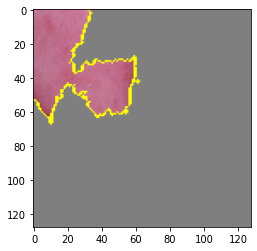

In [39]:
# The predictive boundary of a benign lesion misclassified as unknown
lime_boundaries(benign_incorrect[2])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 17.6 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

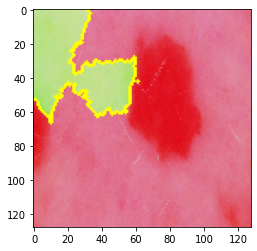

In [40]:
# The pros and cons mask of a benign lesion misclassified as unknown
lime_mask(benign_incorrect[2])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

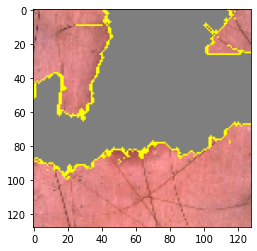

In [27]:
# The predictive boundary of a malignant lesion misclassified as benign
lime_boundaries(malignant_incorrect[2])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

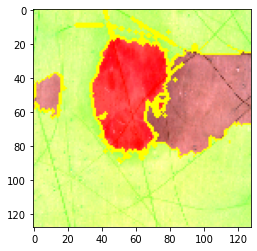

In [28]:
# The pros and cons mask of a malignant lesion misclassified as benign
lime_mask(malignant_incorrect[2])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

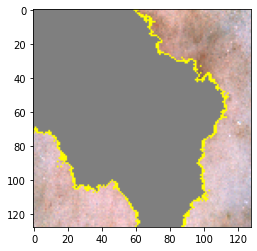

In [29]:
# The predictive boundary of an unknown lesion misclassified as malignant
lime_boundaries(unknown_incorrect[1])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

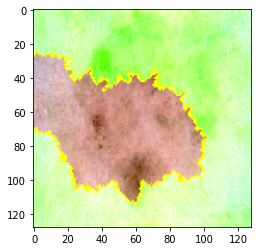

In [30]:
# The pros and cons mask of an unknown lesion misclassified as malignant
lime_mask(unknown_incorrect[1])

### Exploring Correctly Classified Images Using Lime

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

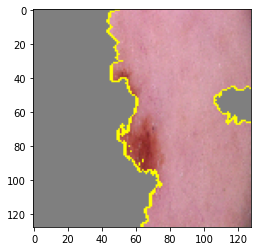

In [37]:
# The predictive boundary of a correctly classified benign lesion
lime_boundaries(benign_correct[5])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

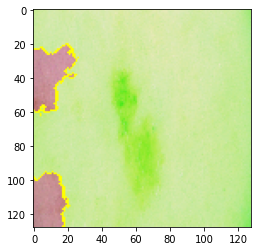

In [38]:
# The pros and cons mask of a correctly classified benign lesion
lime_mask(benign_correct[5])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

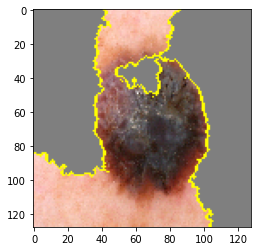

In [53]:
# The predictive boundary of a correctly classified malignant lesion
lime_boundaries(malignant_correct[1])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.2 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

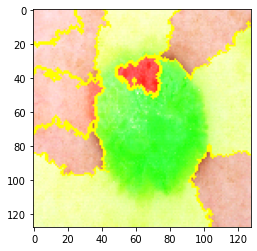

In [54]:
# The pros and cons mask of a correctly classified malignant lesion
lime_mask(malignant_correct[1])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

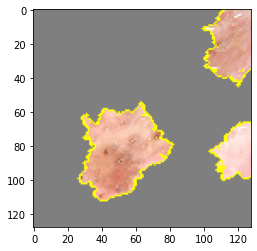

In [55]:
# The predictive boundary of a correctly classified unknown lesion
lime_boundaries(unknown_correct[1])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

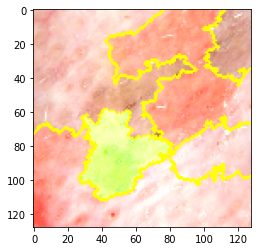

In [56]:
# The pros and cons mask of a correctly classified unknown lesion
lime_mask(unknown_correct[1])

**Analysis:** Ultimately, those features that the model uses to make its predictions remain ambiguous. Although it appears from this brief exploration that the model is focusing on the lesion when it correctly classifies an image, and is focusing on the skin surrounding the lesion when it misclassifies an image, it is important to note that these are three particularly good examples of both correctly classified and misclassified images, and are not representative of how the model made all of its correct and incorrect predictions. There were some correctly classified images where the model used the surrounding skin to make its prediction, and some misclassified images where the model was focusing on the lesion. I would need to investigate further to determine exactly how and why the model predicts each image the way it does. 

## Conclusions

### Recommendations
*   I recommend that this model be used as part of the clinical diagnosis of skin lesions.  
*   If a skin lesion is clinically diagnosed as being benign, I recommend that this model is not used, as medical professional's precision when it comes to diagnosing benign lesions is over 99%.
*   If a skin lesion is clinically diagnosed as being malignant, and the model predicts it to be benign, I recommend that the clinical diagnosis be rejected, as the model is not even half of a percent less precise than medical professionals when it comes to clinically diagnosing lesions as being benign at 98.63%. 
*   If a skin lesion is clinically diagnosed as being malignant, and the model predicts it to be malignant or unknown, I recommend that the clinical diagnosis be confirmed, as the model only misdiagnoses benign lesions as either malignant or unknown 4.80% of the time.
*   Finally, I recommend that this model be used to reduce the number of biopsies taken of misdiagnosed benign lesions.


### Next Steps
*   Get more dermoscopic images of those skin specific types of skin lesions that are underrepresented in the archive.
*   Train a multiclass classifier that predicts specific types of lesions, such as melanoma, basal cell carcinoma, squamous cell caricnoma, etc.








## For More Information

See the full analysis in the [Jupyter Notebook](./.ipynb) or review this [presentation](./.pdf)



### Structure of Repository:

```
├── .ipynb_checkpoints
├── code
├── images
├── models (saved .h5 files of trained models)
├── .gitignore
├── CONTRIBUTING.md
├── LICENSE.md
├── README.md
├── skin_lesion_image_classifier.ipynb
└── skin_lesion_image_classifier_presentation.pdf
```